In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Introduction

In this project we show our implementation of a simple visual Unsupervised Domain Adaptation technique based on Fourier transforms. This work, which for short we call Fourier Domain Adaptation (FDA) was proposed at CVPR 2020 [1] and has shown remarkable improves in the Semantic Segmentation task on various datasets, despite being very simple. 

After implementing the original method, we also show a couple of simple changes and analyze how these affect the performance. We also discuss the motivation of this method and the peculiarity of the particular domains used in the Adaptiope [2] dataset.

In this Notebook, each code cell is preceeded by a cell text explaining the implemented functions and their motivation. More technical details can be found in the comments inside the code cell itself.

Install torchinfo, useful to show inner structure of the backbone model.

In [ ]:
!pip install torchinfo

The following code copies the zipped dataset to the current folder and defines the dataset and experiments root folder. They should be changed if necessary.

In [ ]:
# NB: change this with the actual path of the zipped Adaptiope folder
!unzip '/content/gdrive/MyDrive/Adaptiope.zip'
# this is the folder in which the dataset is expected to be found
ROOT = 'Adaptiope'
# path to which experiments data is saved. Done in google drive by default
EXP_ROOT = 'gdrive/MyDrive/exps'

The following cell performs basic dataset preprocessing. From the original dataset, only two domains are used, and from them a subset of 20 classes defined in the code is selected.

In [ ]:
import os
import subprocess
from os import path, listdir

# list of classes to be used as in assignment document
CLASSES = ['backpack','bookcase','car jack','comb','crown','file cabinet','flat iron','game controller','glasses','helicopter','ice skates','letter tray','monitor','mug','network switch','over-ear headphones','pen','purse','stand mixer', 'stroller']

# remove unused synthetic domain images
subprocess.call('rm -r {}'.format(path.join(ROOT,'synthetic')),shell=True)
# remove classes not in list
for cls in os.listdir(path.join(ROOT,'real_life')):
    if cls not in CLASSES:
        subprocess.call('rm -r {}'.format(path.join(ROOT,'real_life','"'+cls+'"')),shell=True)
        subprocess.call('rm -r {}'.format(path.join(ROOT,'product_images','"'+cls+'"')),shell=True)

# create basic structure folder for experiments and tensorboard runs
subprocess.call('mkdir {}'.format(EXP_ROOT), shell=True)
subprocess.call('mkdir {}/runs'.format(EXP_ROOT), shell=True)
subprocess.call('mkdir {}/checkpoints'.format(EXP_ROOT), shell=True)
subprocess.call('mkdir {}/results'.format(EXP_ROOT), shell=True)
subprocess.call('mkdir debug_viz', shell=True)




This function produces a balanced split of the given dataset and domain. A standard 80/20 split for train/test is used, and the resulting split are represented as list of image names which are then saved in text files. These will be accessed form the AdaptiopeFDADataset class to build the actual dataset.
Note that the produced splits will be class balanced, as the original dataset itself is balanced. 

All the experiments reported later have been produced using the default seed (42) for the train/test split, so that changing it may invalidate the results.

In [ ]:
import random

def make_random_split(data_root, domain, seed=42, valid_ratio=0.2):
    '''
    Given path of dataset in Adaptiope format, makes train/valid split balanced for classes.
    Seed guarantees that the splits are always the same.
    Returns lists with file paths
    '''

    train_files, valid_files = [],[]

    random.seed(seed)

    path = os.path.join(data_root, domain)
    for class_folder in os.listdir(path):
        # read all images of specific class    
        file_list = os.listdir(os.path.join(path, class_folder))
        
        complete_paths = [os.path.join(domain, class_folder, file_path) for file_path in file_list]
        sample_all = len(file_list)
        sample_valid = int(sample_all * valid_ratio)
        
        # shuffle and partition the list in train and validation splits
        random.shuffle(complete_paths)
        train_files.extend(complete_paths[sample_valid:])
        valid_files.extend(complete_paths[:sample_valid])
    
    return train_files, valid_files

# make train/test splits for both domains
train_real, valid_real = make_random_split(ROOT,'real_life')
train_product, valid_product = make_random_split(ROOT,'product_images')

# save txt file with partition file paths
with open('real_life_train.txt','w') as f:
    for path in train_real:
        f.write(path + '\n')
with open('real_life_valid.txt','w') as f:
    for path in valid_real:
        f.write(path + '\n')

with open('product_images_train.txt','w') as f:
    for path in train_product:
        f.write(path + '\n')
with open('product_images_valid.txt','w') as f:
    for path in valid_product:
        f.write(path + '\n')


The following cell defines a set of very simple image transformation used in dataset. Some of them (to_tensor, resize, normalize) are utility functions with a deterministic output, while the other are used as image augmentations to improve generalization.

In [ ]:
from torchvision.transforms import functional as F
import numpy as np

# sample from image to tensor
class to_tensor(object):
    def __call__(self, sample):
        
        return(
            torch.tensor(np.asarray(sample[0]).transpose(2, 0, 1), dtype=torch.float32).div(255),
            torch.tensor(np.asarray(sample[1]), dtype=torch.long)
        )

# resize image to givan shape
class resize(object):
    def __init__(self, size_out):
        self.size_out = size_out
    
    def __call__(self, sample):
        
        height_out, width_out = self.size_out
        
        return (
            F.resize(sample[0], (height_out, width_out), interpolation=F.InterpolationMode.BILINEAR),
            sample[1]   
        )

# randomly applies gaussian blur to image
class random_blur(object):
    def __init__(self, prob=.5, kernel=7):
        self.p = prob
        self.kernel = kernel

    def __call__(self, sample):
        if random.random() < self.p:
            return (
                F.gaussian_blur(sample[0], kernel_size=self.kernel), 
                sample[1]
            )
        else:
            return sample

# randomly changes image brightness
class random_brightness(object):
    def __init__(self, prob=.5):
        self.p = prob

    def __call__(self, sample):
        if random.random() < self.p:
            return (
                torchvision.transforms.ColorJitter(brightness=.25, contrast=.0, saturation=.0, hue=.00)(sample[0]),
                sample[1]
            )
        else:
            return sample

# randomly applies color jittering
class color_jitter(object):
    def __init__(self, prob=.5):
        self.p = prob

    def __call__(self, sample):
        if random.random() < self.p:
            return (
                torchvision.transforms.ColorJitter(brightness=.125, contrast=.5, saturation=.5, hue=.05)(sample[0]),
                sample[1]
            )
        else:
            return sample

# random horizontal flip
class horizontal_flip(object):
    def __init__(self, prob=.5):
        self.p = prob

    def __call__(self, sample):
        if random.random() < self.p:
            return (
                F.hflip(sample[0]),
                sample[1]
            )
        else:
            return sample

# random vertical flip
class vertical_flip(object):
    def __init__(self, prob=.5):
        self.p = prob

    def __call__(self, sample):
        if random.random() < self.p:
            return (
                F.vflip(sample[0]),
                sample[1]
            )
        else:
            return sample

# random rotation in 45 degrees
class rotation(object):
    def __init__(self, prob=.5):
        self.p = prob
        self.angles = [i*45. for i in range(1,8)]

    def __call__(self, sample):
        if random.random() < self.p:
            angle = np.random.choice(self.angles)
            return (
                F.rotate(sample[0], angle),
                sample[1]
            )
        else:
            return sample

# normalizes given image statistics
class normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        return (
            F.normalize(sample[0], mean=self.mean, std=self.std),
            sample[1]
        )

This cell defines the function which builds the logget, which is used for tracking an experiment operation in a simple and effective way.

In [ ]:
def get_logger(path_log):

    # get logger
    logger = logging.getLogger('log')
    logger.setLevel(logging.INFO)
    # this is necessary in Colab, apparently the handler is retained when executing the cell
    logger.handlers.clear()
    # get formatter
    formatter = logging.Formatter('%(asctime)s - %(message)s')

    # get file handler and add it to logger
    # in this way, the logger will write to both the console and the specified file
    fh = logging.FileHandler(path_log, mode='w')
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    # get console handler
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger.addHandler(ch)

    logger.propagate = False

    return logger

# Fourier Domain Adaptation

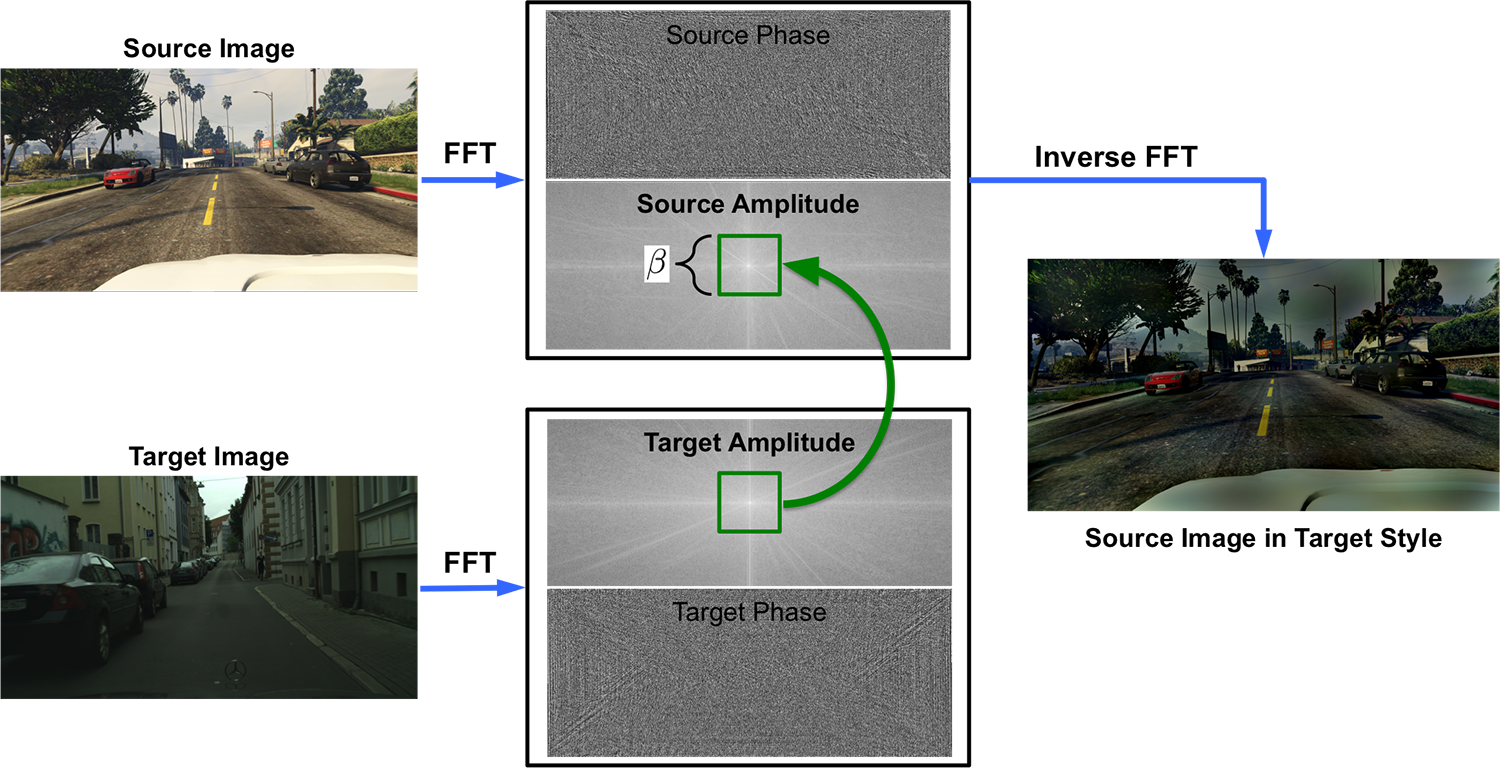

The previous image, taken from the original FDA paper, briefly shows how the method works. First, a source and a target image are randomly sampled from the respective domains and are paired together. The FFT (Fast Fourier Transform) algorithm is then applied to move the images in the Fourier space, giving amplitude and phase for each image. Then, a lower interval of frequencies (parametrized by $β$, ranging from 0 to 1) is selected on the target image transforms and "swapped" on the same interval on the source image. The resulting modified source spectrum is then translated back to the image space by the inverted FFT algorithm.

The resulting image retains all of the semantic characteristics of the original source image, but the change in lower frequencies cause a general change in luminosity and color which makes it more similar to the target image. At this point, the modified source image can be used to train a Deep Learning architecture without any particulat architectural changes. 

## Flexibility

The resulting method is very flexible, as it could be used in different types of visual tasks without the need for architectural adaptation, and has shown results comparable to the SOTA at the time of publication. Note that the method is agnostic to the particular task to be performed. In fact, in the original work this method is used for a Semantic Segmentation task, while in this work we are tackling the problem of Object Recognition.

## Motivation

In the original work, the authors state that the cut-and-paste of the Fourier lower frequencies are equivalent to injecting in the source images the statistics of the target images. The core idea, in fact, is that while higher frequencies component mantain the semantic characteristics of the image (edges, texture etc.), low level component are less semantically meaningful, but are responsible for a change in statistics which harms the model when testing on a different domain. For this reason, swapping the lower frequence spectrum helps in the task.

### Choice of $β$ and FDA modalities

In this work we implemented the original FDA as well as two simple variations:

- Default: the default implementantion follows the above description. In this setting, only the $β$ hyperparameter has to be choosen. Following the original work, we tried different values to see what best fits the provided dataset.

- Random $β$: in this simple variation, the $β$ value is choosen randomly for each image in a certain interval (in all experiments with this setting, this is set to (0.005, 0.1)). The motivation for this work is given by the fact that, in the original work, it is shown how the performance can change by a good extent with the variation of this hyperparameter. This is also confirmed by our experiments in the default settings. Because of this, we decided to try to randomize the $β$, also in order to make the model more robust to change in image statistics. A possible problem with this method is that two $β$ values must be choosen instead of a single one. Moreover, the $β$ is drawn from a uniform distribution in the specified interval, but this could easily be changed.

- Interval: in the context of the Adaptiope dataset, we noticed that the Product domain shows images with a completely white background. This would clearly influence a lot the lower Fourier frequency in the domain spectrum: by injecting this type of low level spectrum, we could inject in the source images frequencies which do not result from the normal variance whitin a dataset domain, but are instead caused by a specific artifact (the white background) in the domain. Because of this, we deem interesting to try a simple variation of FDA which exclude from the swapping a small set of frequencies around zero. That is, instead of swapping the 10% lowest frequencies (assuming $β=0.1$) we will only swap the set between, say, 5 and 10%. This means that we are assuming that the more informative statistics of the target dataset lie within this interval, while the frequencies lower than the low threshold are ignored, as resulting from domain artifact. In the experiment whit this setting, the interval choosen is (0.005, 0.05). This method exhibit the same problem of the Random FDA setting, which is the fact that two hyperparameters must be chosen, instead of only one.

The following code shows the implementation of the FDA pipeline given a source and a target image.

In [ ]:
import math

def apply_fda(source_img, target_img, betas):

    min_b, max_b = betas
    
    # using fft, get source in target in fourier domain
    # this function outputs the fourier transform in complex number
    target_f = torch.fft.fft2(target_img.clone())
    source_f = torch.fft.fft2(source_img.clone()) 

    # switch from complex number formulation to amplitude and phase
    target_amp, source_amp = torch.abs(target_f), torch.abs(source_f)
    # phase of target is not used, only source is necessary
    source_phase = torch.angle(source_f)

    # amplitude is given with positive frequencies first and then negative frequencies
    # fftshift change this to center 0 frequence at the center of the image
    # this makes spectrum substitution easier in the code
    source_shifted_amp = torch.fft.fftshift(source_amp, dim=(-2, -1))
    target_shifted_amp = torch.fft.fftshift(target_amp, dim=(-2, -1))

    # clone source, may be necessary in the frequency interval setting
    source_shifted_amp_clone = source_shifted_amp.clone()

    # get image shape (assuming square image) and compute bounds
    dim = source_shifted_amp.shape[1]
    bound = int(math.floor(dim * max_b))
    img_center = int(math.floor(dim/2))

    l_bound = img_center - bound
    u_bound = img_center + bound + 1

    # substitute frequency
    source_shifted_amp[:,l_bound:u_bound, l_bound:u_bound] = target_shifted_amp[:,l_bound:u_bound, l_bound:u_bound]

    # if this is true, we are in the frequency interval setting
    if min_b > 0:
        # repeat the same operations as above, but restore to the original source the frequencies lower than the bound
        bound = int(math.floor(dim * min_b))
        img_center = int(math.floor(dim/2))

        l_bound = img_center - bound
        u_bound = img_center + bound + 1

        #print('Applying lower bound: {}, {}'.format(l_bound, u_bound))

        source_shifted_amp[:,l_bound:u_bound, l_bound:u_bound] = source_shifted_amp_clone[:,l_bound:u_bound, l_bound:u_bound]

    # finally, get back to the default amplitude representation by inverting the shift operation
    source_new_amp = torch.fft.ifftshift(source_shifted_amp, dim=(-2, -1))
    
    # to reconstruct the image, we need the complex representation of the fourier transform
    # to obtain this, multiply the FDA-augmented amplitude with the exponential of the original source phase
    source_new_f =  source_new_amp * torch.exp(1j * source_phase)

    # finally, invert the fourier transform and get an image back
    source_new_img = torch.fft.ifft2(source_new_f, dim=(-2, -1))
    source_new_img = torch.real(source_new_img)

    return source_new_img

Dataset for loading Adaptiope dataset and, if option allows, apply FDA. If FDA is not applied, the dataset will simply load the given partition and return the images with the random augmentations applied, if set. Otherwise, if FDA is applied also a target domain must be choosen, and the target images will also be loaded. Each source image will be randomly paired with a target image to apply the spectrum swap operation.

In [ ]:
import os
import random
from torch.utils.data import Dataset
import logging
import matplotlib.pyplot as plt
from PIL import Image


class AdaptiopeFDADataset(Dataset):
    '''
    Dataset to handle image loading and transformations
    '''

    def __init__(self, root, split, source_domain, target_domain=None, transforms=None, apply_fda=False, beta_fda=None, type_fda='default', image_size=(224,224)):
        super(AdaptiopeFDADataset, self).__init__()

        self.transforms = transforms
        self.root = root
        self.source_domain = source_domain
        self.target_domain = target_domain
        self.split = split
        self.apply_fda = apply_fda
        self.beta_fda = beta_fda
        self.type_fda = type_fda
        self.image_size = image_size

        # makes double dictionary to associate class name and assigned class id
        self.id2class = {k:name for k, name in enumerate(os.listdir(os.path.join(root,source_domain)))}
        self.class2id = {name:k for k, name in self.id2class.items()}
        self.n_classes = len(self.class2id.keys())

        # build list of source data path
        self.all_data = []
        self.all_annots = []

        file_path = '{}_{}.txt'.format(source_domain,split)

        # build parallel list containing image path and class
        with open(file_path) as f:
            for img_path in f.readlines():
                cls_name = img_path.split('/')[1]
                cls_id = self.class2id[cls_name]
                self.all_data.append(os.path.join(root, img_path))
                self.all_annots.append(cls_id)

        if self.apply_fda:
            # similarly for target, but only for images, classes cannot be used
            file_path = '{}_{}.txt'.format(target_domain,split)
            self.target_data = []

            with open(file_path) as f:
                for img_path in f.readlines():
                    self.target_data.append(os.path.join(root, img_path))

            random.shuffle(self.target_data)

    def __getitem__(self, index):

        # read image, produce sample. Removes last two chars (\n) from path
        src_image = Image.open(self.all_data[index][:-1])
        gt = self.all_annots[index]
        
        sample = (src_image, gt)
        # move to tensor, apply resizing
        src_image = torch.tensor(np.asarray(src_image).transpose(2,0,1), dtype=torch.float)
        src_image = F.resize(src_image, self.image_size, interpolation=F.InterpolationMode.BILINEAR)

        # apply fda!
        if self.apply_fda:

            # randomly select a target image
            tgt_index = np.random.choice(len(self.target_data))
            tgt_image = Image.open(self.target_data[tgt_index][:-1])

            # single static value, as in original paper
            if self.type_fda == 'default':
                betas = (0., self.beta_fda)
            
            # single value randomly generated in a fixed interval
            elif self.type_fda == 'random':
                min_b, max_b = 0.005, 0.1
                beta = min_b + np.random.random_sample() * (max_b - min_b)
                betas = (0., beta)

            # interval: substitute spectrum only in a fixed frequency range
            elif self.type_fda == 'interval':
                betas = (0.005, 0.05)
            else:
                raise RuntimeError('Error')

            # resize it like the source img
            tgt_image = torch.tensor(np.asarray(tgt_image).transpose(2,0,1), dtype=torch.float)
            tgt_image = F.resize(tgt_image, self.image_size, interpolation=F.InterpolationMode.BILINEAR)
            
            # call FDA function
            src_image = apply_fda(src_image, tgt_image, betas)
            # fix bounds by re-normalizing between 0 and 1
            min_b, max_b = torch.amin(src_image, dim=(1,2)), torch.amax(src_image, dim=(1,2))
            min_b, max_b = min_b.view(3,1,1), max_b.view(3,1,1)

            src_image = 255 * (src_image - min_b) / (max_b - min_b)

        src_image = src_image.div(255.)

        # eventually apply augmentations
        t_sample = self.transforms((src_image, torch.tensor(gt))) 

        # flag for saving to disk generated images
        if DEBUG:
            filename = os.path.split(self.all_data[index])[1]
            debug_augs(sample, t_sample, filename)

        return t_sample

    def __len__(self):
        return len(self.all_data)


The following cell contains two functions.
The first is used to prepare the experiment data given the experiment configuration file. This means creating the exp folder, making a copy of the config file for further reference, and set up both the tensorboard and the logger file.

The second function is used to compute the image statistics (expected value and standard deviation, for each RGB channel) of a dataset partition. This is necessary to perform the normalization operation on the images which is carried out in most experiments. Note that this code will not run by default: this function is used to generated the statistics which are then hardcoded, and we chose to put this function just as a reference. Calculating statistics each time requires about 10 minutes and would reduce the experiment speed.

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def init_exp_data(config):
    '''
    Handles folder creation and init helpers (tensorboard writer, logger, config file)
    '''

    # get copy of config to save on exp folder for reproducibility
    exp_name = config['exp_name']
    exp_root_dir = join('{}/checkpoints/{}'.format(EXP_ROOT,exp_name))
    exp_run_dir = join('{}/runs/{}'.format(EXP_ROOT,exp_name))

    # make folder and copy config in it
    if not os.path.isdir(exp_root_dir): 
        subprocess.call('mkdir {}'.format(exp_root_dir), shell=True)
    with open('{}/config.json'.format(exp_root_dir),'w') as f:
        json.dump(config, f)

    # get logger file and prepare folder for tensorboard run
    log_file = join(exp_root_dir,'log_train.txt')
    
    logger = get_logger(log_file)
    
    # make tensorboard writer
    if not os.path.exists(exp_run_dir):
        subprocess.call('mkdir {}/runs/{}'.format(EXP_ROOT, exp_name), shell=True)
    else:
        subprocess.call('rm {}/runs/{}/*'.format(EXP_ROOT, exp_name), shell=True)
    writer = SummaryWriter(log_dir='{}/runs/{}'.format(EXP_ROOT, exp_name))

    return config, writer, logger

def compute_partition_statistics(data_root, domain, file_list):
    '''
    Compute image statistics for normalization given a list of image files
    '''

    # mean and std accumulated for each image channel
    acc_mean, acc_std = np.zeros((3)), np.zeros((3))
    n_images = 0

    for cls, cls_file_list in file_list.items():
        n_images += len(cls_file_list)
        for path in tqdm(cls_file_list):

            # read image
            img_path = os.path.join(data_root, domain, cls, path)
            img = np.asarray(Image.open(img_path))

            # rgb channel should be last dimension
            assert img.shape[2] == 3

            acc_mean += np.mean(img,axis=(0,1))
            acc_std += np.std(img,axis=(0,1))
    
    final_mean = acc_mean / n_images
    final_std = acc_std / n_images

    return final_mean, final_std


The following cell contains the code responsible for building the basics block of the training pipeline. The code was designed to be as modular as possible, and to allow the various part of the architecture (backbone, optimizer, scheduler, datasets) to be easily swapped. The general structure is the same for all functions: given the config file which specifies the experiment detail, the function will create and return the pipeline component considering the fields in the config.

In [ ]:
def get_augmentations(split, config, mean, std):

    '''
    Get transformations given the config.
    Partition statistics are need for normalization
    '''

    # resize always performed
    transforms_list = [resize(config['img_size'])]

    # add random augs on training only
    if config['use_transforms'] and split != 'valid':
        transforms_list.extend([
            rotation(0.5),
            vertical_flip(0.5),
            horizontal_flip(0.5),
            color_jitter(0.5), 
            random_brightness(0.5), 
            random_blur(0.5)
        ])

    # add normalization
    if config['normalize']:
        transforms_list.append(normalize(mean, std))

    # compose and return
    transforms = torchvision.transforms.Compose(transforms_list)

    return transforms

def get_dataloader(domain, split, config, logger):

    '''
    Given setting and domain, makes dataloader without the FDA option.
    Used, for example, on partition used for test/validation
    '''

    t0 = time.time()

    data_root = config['data_root']
    bs = config['bs']

    # statistics were computed with compute_statistics function
    # stored here instead of calculating each time, as it takes about 10 minutes for training split of both domains
    if domain == 'real_life':
        mean = np.asarray([126.14347108, 113.91401873, 104.23854951]) / 255.
        std = np.asarray([62.19862685, 60.15504673, 58.31924106]) / 255.
    # note how statistics on product images are very different
    elif domain == 'product_images':
        mean = np.asarray([204.15382516, 201.85979188, 201.61542635]) / 255.
        std = np.asarray([68.72443387, 70.93535685, 71.42282813]) / 255.
    else:
        raise RuntimeError('Domain {} not found.'.format(domain))

    transforms = get_augmentations(split, config, mean, std)

    drop_last = (split == 'valid')

    # get dataset without doing fda
    dataset = AdaptiopeFDADataset(
        root=data_root,
        split=split,
        source_domain=domain,
        target_domain=None,
        image_size=config['img_size'],
        transforms=transforms
    )

    # get dataloader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=drop_last
    )

    logger.info('Loaded {} {} samples for domain {} in {:.3f} s.'.format(len(dataset), split, domain, time.time()-t0))
    
    return dataloader, (mean, std)

def get_fda_dataloader(source_domain, target_domain, split, config, logger):

    '''
    Given setting and domain, makes dataloader when using FDA. This also require having the target domain.
    '''

    t0 = time.time()
    data_root = config['data_root']
    bs = config['bs']

    logger.info('Source domain: {}'.format(config['source_domain']))
    logger.info('Target domain: {}'.format(config['target_domain']))
    if config['use_fda']:
        logger.info('Using FDA in {} setting'.format(config['type_fda']))
    else:
        logger.info('BASELINE: not using FDA')


    # statistics were computed with compute_statistics function
    # stored here instead of calculating each time, as it takes about 10 minutes for training split of both domains
    if source_domain == 'real_life':
        mean = np.asarray([126.14347108, 113.91401873, 104.23854951]) / 255.
        std = np.asarray([62.19862685, 60.15504673, 58.31924106]) / 255.
    # note how statistics on product images are very different
    elif source_domain == 'product_images':
        mean = np.asarray([204.15382516, 201.85979188, 201.61542635]) / 255.
        std = np.asarray([68.72443387, 70.93535685, 71.42282813]) / 255.
    else:
        raise RuntimeError('Domain {} not found.'.format(source_domain))

    transforms = get_augmentations(split, config, mean, std)

    drop_last = (split == 'valid')

    # get dataset
    dataset = AdaptiopeFDADataset(
        root=data_root,
        split=split,
        source_domain=source_domain,
        target_domain=target_domain,
        apply_fda=config['use_fda'],
        beta_fda=config['beta_fda'],
        type_fda=config['type_fda'],
        image_size=config['img_size'],
        transforms=transforms
    )

    # get dataloader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=drop_last
    )

    logger.info('Loaded {} {} samples for domain {} in {:.3f} s.'.format(len(dataset), split, source_domain, time.time()-t0))
    
    return dataloader, (mean, std)

def get_model(config):
    '''
    Returns CNN model
    '''

    arch = config['arch']
    dropout = config['dropout']



    if arch == 'resnet18':
        # if using torchvision resnet18, must change last classification layer
        model = torchvision.models.resnet18()
        fc = torch.nn.Linear(512, config['n_classes'])
    elif arch == 'resnet34':
        # same for resnet34
        model = torchvision.models.resnet34()
        fc = torch.nn.Linear(512, config['n_classes'])
    elif arch == 'resnet50':
        # same for resnet50
        model = torchvision.models.resnet50(pretrained=True)
        fc = torch.nn.Linear(2048, config['n_classes'])
    elif arch == 'custom_resnet50':
        model = ResNet50_DA()
        fc = torch.nn.Linear(2048, config['n_classes'])
    else:
        raise RuntimeError('Architecture {} not implemented!'.format(arch))

    if dropout > 0.:
        model.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout),
            fc
        )
    else:
        model.fc = fc

    return model

def get_optimizer(model, config):
    
    '''
    Given the model and config, builds the optimizer
    '''

    lr = config['lr']
    w_decay = config['w_decay']
    opt = config['optimizer']
    params = model.parameters()

    if opt == 'sgd':
        optimizer = torch.optim.SGD(params=params, lr=lr, momentum=0.9, weight_decay=w_decay)
    elif opt == 'adam':
        optimizer = torch.optim.Adam(params=params, lr=lr, weight_decay=w_decay)
    else:
        raise RuntimeError('Optimizer {} not implemented!'.format(opt))

    return optimizer

def get_scheduler(optimizer, config):
    '''
    Makes the scheduler for the optimizer lr
    '''    

    sched = config['scheduler']
    n_epochs = config['n_epochs']
    lr = config['lr']

    # by default, lr is lowered by a factor of 0.1 after 50%, 75% and 90% of training epochs are done
    if sched == 'step':
        milestones = [int(frac * n_epochs) for frac in [0.5,0.75,0.9]]
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
        
    # cosine annealing scheduler, lowering from lr to 0.1*lr
    elif sched == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=n_epochs, eta_min=lr*0.1)

    # fake scheduler: lr is never updated
    elif sched is None:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[n_epochs+1], gamma=0.1)
    
    else:
        raise RuntimeError('Scheduler {} not implemented!'.format(sched))

    return scheduler

The following code defines the train and evaluation scripts. The functions are divided in order to provide modular train/validation procedures on a single batch and on a single training epoch.

In [ ]:
import torch

def train_epoch(dataloader, model, loss_fn, optimizer):
    '''
    Trains for a single epoch the model with the given optimizer, loss and dataloader
    '''

    # accumulate epoch, accuracy and gradients statistics
    epoch_loss = 0.
    epoch_acc = 0.
    epoch_grad_mean = 0.
    epoch_grad_max = 0.

    t0 = time.time()
    for batch in dataloader:    
        
        # get and accumulate loss and accuracy for current batch
        cur_loss, cur_acc = train_batch(batch, model, loss_fn, optimizer, None)
        epoch_loss += cur_loss
        epoch_acc += cur_acc

        # it can be useful to register mean and max gradients to look for vaninishing/exploding gradients problem
        grad_mean = 0.0
        grad_max = 0.0
        num_layers = 0
        for n, p in model.named_parameters():
            if p.requires_grad and p.grad is not None:
                grad_mean += torch.mean(p.grad).item()
                grad_max += torch.max(p.grad).item()
                num_layers += 1
        # values are averaged across number of layers
        grad_mean /= num_layers
        grad_max /= num_layers
        epoch_grad_mean += grad_mean
        epoch_grad_max += grad_max

    # compute mean of epoch and return
    epoch_loss = epoch_loss / len(dataloader)
    epoch_acc = epoch_acc / len(dataloader)
    epoch_mean = epoch_grad_mean / len(dataloader)
    epoch_max = epoch_grad_max / len(dataloader)

    time_elapsed = time.time() - t0

    return epoch_loss, epoch_acc, epoch_mean, epoch_max, time_elapsed 

def valid_epoch(dataloader, model, loss_fn):
    '''
    Given a model, validates it with the given loss and dataloader
    '''

    # as in training, accumulate loss and accuracy. No gradients here of course
    epoch_loss = 0.
    epoch_acc = 0.

    t0 = time.time()
    for batch in dataloader:    

        # same as in training
        cur_loss, cur_acc = valid_batch(batch, model, loss_fn, None)

        epoch_loss += cur_loss
        epoch_acc += cur_acc

    epoch_loss = epoch_loss / len(dataloader)
    epoch_acc = epoch_acc / len(dataloader)
    time_elapsed = time.time() - t0

    return epoch_loss, epoch_acc, time_elapsed 

def train_batch(databatch, model, loss_fn, optimizer, config):

    '''
    Trains the given model on a single batch, with given optimizer and loss.
    '''

    # set model to train mode
    model.train()
    # get data, send to gpu
    x,y = databatch
    x = x.to('cuda')
    y = y.to('cuda')
    # zeros optimizers grads
    optimizer.zero_grad()
        
    # get prediction, compute loss and backpropagate
    # no need to softmax predictions, Pytorch crossE loss requires unnormalized scores
    pred_y = model(x)
    
    cur_loss = loss_fn(pred_y, y)
    cur_loss.backward()
    
    # apply optimizer to update internal params
    optimizer.step()

    # also compute accuracy
    acc = compute_accuracy(pred_y, y)

    return cur_loss, acc

def valid_batch(databatch, model, loss_fn, config):
    '''
    Evaluates a given model on a single batch, with given loss.
    '''

    # set to evalution mode
    model.eval()
    
    # apply torch.no_grad
    with torch.no_grad():
    
        # as in train_batch, but without optimizer and backpropagation
        x,y = databatch
        x = x.to('cuda')
        y = y.to('cuda')
            
        pred_y = model(x)
        cur_loss = loss_fn(pred_y, y)

        acc = compute_accuracy(pred_y, y)


    return cur_loss, acc


The following two methods are necessary respectively to compute accuracy and to save a checkpoint of the trained model during an experiment.

In [ ]:
def compute_accuracy(pred_logits, gt_class):
    '''
    Given unnormalized preditions score and classification ground truth, computes accuracy
    '''

    # get actual predicted class
    pred_class = torch.argmax(pred_logits, dim=-1)
    # correct samples and all samples
    correct = torch.sum(pred_class == gt_class).float()
    all = gt_class.shape[0]

    accuracy = correct / all

    return accuracy.item() * 100.

def save_checkpoint(model, optimizer, config, epoch, source_stats, target_stats):

    exp_dir = '{}/checkpoints/{}'.format(EXP_ROOT, config['exp_name'])

    # save in checkpoint normalization statistics
    # in this way the evaluation can be carried out by taking the training stats from the checkpoint directly
    if config['normalize']:
        source_mean, source_std, target_mean, target_std = source_stats[0], source_stats[1], target_stats[0], target_stats[1]
    else:
        source_mean, source_std, target_mean, target_std = None, None, None, None

    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'source_mean' : source_mean,
        'source_std' : source_std,
        'target_mean' : target_mean,
        'target_std' : target_std,
    }, join(exp_dir, 'checkpoint_last.pth'))


Our implementation of the Resnet50. This has been written by considering both the indication on the original paper and the code provided by the torchvision model.

In [ ]:
import torch
import torch.nn as nn

class IdentityBottleneck(nn.Module):
    '''
    Standard bottleneck as in Resnet50, whitout any downsampling
    '''
    def __init__(self, in_channels, inner_channels):
        super(IdentityBottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_channels, (1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)

        self.conv2 = nn.Conv2d(inner_channels, inner_channels, (3,3), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        
        self.conv3 = nn.Conv2d(inner_channels, in_channels, (1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(in_channels)

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):

        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.act(x1)

        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.act(x1)

        x1 = self.conv3(x1)
        x1 = self.bn3(x1)
        x1 = x1 + x # apply skip connection
        
        x1 = self.act(x1)

        return x1

class DownsamplingBottleneck(nn.Module):
    '''
    Similar to above block, but also performs downsampling by convolution with stride 2
    '''
    def __init__(self, in_channels, inner_channels, out_channels):
        super(DownsamplingBottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, inner_channels, (1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)

        # as in original resnet, spatial downsampling is done by conv layer with stride 2
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, (3,3), stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        
        self.conv3 = nn.Conv2d(inner_channels, out_channels, (1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU(inplace=True)

        # need to downsample the skip connection as well, done by using a 1x1 convolution like in original paper
        self.downsample = torch.nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (1,1), stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.act(x1)

        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.act(x1)

        x1 = self.conv3(x1)
        x1 = self.bn3(x1)
        x = self.downsample(x)
        x1 = x1 + x
        x1 = self.act(x1)

        return x1

class ResNet50_DA(nn.Module):
    def __init__(self, img_channels=3, n_classes=20):
        
        super(ResNet50_DA, self).__init__()

        self.n_classes = n_classes
        self.init_conv = nn.Conv2d(3, 64, kernel_size=(7,7), stride=2, padding=3, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.act = nn.ReLU(inplace=True)
        self.init_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.hidden_layers = nn.Sequential(
            DownsamplingBottleneck(64,64,256),
            IdentityBottleneck(256,64),                             
            IdentityBottleneck(256,64),
            DownsamplingBottleneck(256,128,512),
            IdentityBottleneck(512,128),                             
            IdentityBottleneck(512,128),
            IdentityBottleneck(512,128),
            DownsamplingBottleneck(512,256,1024),
            IdentityBottleneck(1024,256),                             
            IdentityBottleneck(1024,256),
            IdentityBottleneck(1024,256),
            IdentityBottleneck(1024,256),
            IdentityBottleneck(1024,256),
            DownsamplingBottleneck(1024,512,2048),
            IdentityBottleneck(2048,512),                             
            IdentityBottleneck(2048,512)
        )

        self.final_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, self.n_classes)

        # initialize weights as in Pytorch resnet implementation
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.init_bn(x)
        x = self.act(x)
        x = self.init_pool(x)

        feats_x = self.final_pool(self.hidden_layers(x))
        BS = feats_x.shape[0]
        class_logits = self.fc(feats_x.view(BS,-1))
        #class_logits = torch.softmax(class_logits,dim=-1)
        
        return class_logits

    

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=gdrive/MyDrive/exps/runs

Training loop to perform a single experiment.

In [ ]:
from os.path import join
import os
import json
import time
import subprocess
import torch
import torchinfo
import torchvision
from configparser import ConfigParser
import torch.nn as nn
from torchvision.models import resnet34
from torch.utils.tensorboard import SummaryWriter

def run_experiment(config_name):

    # get tensorboard and logger
    config, writer, logger = init_exp_data(config_name)

    exp_dir = '{}/checkpoints/{}'.format(EXP_ROOT, config['exp_name'])
    src_domain, tgt_domain = config['source_domain'], config['target_domain']
    train_split, valid_split = config['train_split'], config['valid_split']

    # double validation: on same and different domain
    # use fda dataloader: consider also target domain if config is set
    train_dataloader, source_stats = get_fda_dataloader(src_domain, tgt_domain, train_split, config, logger)

    # for validation just use standard dataloader
    _, target_stats = get_dataloader(tgt_domain, train_split, config, logger)
    valid_source_dataloader, _ = get_dataloader(src_domain, valid_split, config, logger)
    valid_target_dataloader, _ = get_dataloader(tgt_domain, valid_split, config, logger)


    # get model, optimizer and scheduler
    model = get_model(config)

    optimizer = get_optimizer(model, config)
    scheduler = get_scheduler(optimizer, config)

    bs = config['bs']
    img_size = config['img_size']
    epochs = config['n_epochs']
    valid_freq = config['valid_freq']
    save_freq = config['save_freq']

    # torchinfo useful to get an overview of the model complexity
    logger.info('Model summary:')
    stats = torchinfo.summary(model, data=torch.rand((bs, 3, img_size[0], img_size[1])))
    logger.info(stats)

    # default crossE loss for classification
    loss = torch.nn.CrossEntropyLoss()                                        

    model = model.cuda()

    # train-validation loop   
    for epoch in range(epochs):

        # get and log epoch statistics
        train_loss, train_acc, grad_mean, grad_max, time_elapsed = train_epoch(train_dataloader, model, loss, optimizer)    

        # log learning rate, gradients and metrics
        writer.add_scalar('Train/Learning rate', optimizer.param_groups[0]['lr'], epoch)
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Accuracy', train_acc, epoch)
        writer.add_scalar('Train/Grad max', grad_max, epoch)
        writer.add_scalar('Train/Grad mean', grad_mean, epoch)
        
        logger.info('TRAIN   Epoch {:3d} : Loss {:.3f}, Accuracy {:.1f}, Time {:.2f} s'.format(epoch, train_loss, train_acc, time_elapsed))

        # interval for validation, both on source and on target domains
        if (epoch+1) % valid_freq == 0:
            
            ####### validation on source domain
            
            epoch_source_loss, epoch_source_acc, time_elapsed = valid_epoch(valid_source_dataloader, model, loss)

            writer.add_scalar('Valid-Source/Loss', epoch_source_loss, epoch)
            writer.add_scalar('Valid-Source/Accuracy', epoch_source_acc, epoch)
            logger.info('VALID-S Epoch {:3d} : Loss {:.3f}, Accuracy {:.1f}, Time {:.2f} s'.format(epoch, epoch_source_loss, epoch_source_acc, time_elapsed))
            

            ####### validation on target domain
            
            epoch_target_loss, epoch_target_acc, time_elapsed = valid_epoch(valid_target_dataloader, model, loss)

            writer.add_scalar('Valid-Target/Loss', epoch_target_loss, epoch)
            writer.add_scalar('Valid-Target/Accuracy', epoch_target_acc, epoch)
            logger.info('VALID-T Epoch {:3d} : Loss {:.3f}, Accuracy {:.1f}, Time {:.2f} s'.format(epoch, epoch_target_loss, epoch_target_acc, time_elapsed))
            
        ### save checkpoint at given frequency
        if (epoch+1) % save_freq == 0:
            save_checkpoint(model, optimizer, config, epoch, source_stats, target_stats)
            logger.info('Saving checkpoint at {}'.format(join(exp_dir,'checkpoint_last.pth')))

        # epoch done, apply step to the scheduler
        scheduler.step()



# Experiments
The performed experiments can be divided in two settings. In each setting, two experiments without UDA are performed, one training on Product and testing on Real domain, and one the other way around. In each experiment, the model is trained on the train partition of the source domain and it is evaluated every 5 epochs on the test split of both the target AND the source domain. In this way, we can get for each experiment both a theoretical upper bound for the performance and a baseline as well.

## Setting 1: Pretrained ResNet50
This is the main setting in which we carried out the experiment and tested our method. As a backbone, we use a pretrained ResNet50 [3] from the popular Torchvision [4] Python library. This model is optimized using an SGD with lr=4e-5 and momentum=0.9, with cosine annealing to lower the learning rate from 4e-5 to 4e-6 during the course of the 100 training epochs. The batch size is set to 64 images. The chice of the hyperparameters comes from the original Adaptiope paper which uses these settings, apart from the cosine annealing which has been added by us. The reason of this choice is to lower the learning rate during training in order to avoid overfitting, as the training data used here is a subset of the original Adaptiope.

To improve generalization and avoid overfitting, we also employ standard data augmentation (color jittering, blurring, flipping, rotating) image normalization and a weight decay factor of 5e-4 on the optimizer. The effectiveness of this approach is shown in the Table below, which list the accuracy scores on the test set in the baseline experiments, using the same domain (but different split) for training and test.

As in the original Resnet paper INSERT LINK, we resize the images to a standard size of 224x224 prior to applying augmentations and feeding them to the model. We adopted a standard CrossEntropy loss for the classification task, and measure the performance in Accuracy.

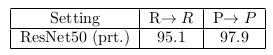

We also added an option to employ dropout on the final layer, but it turned out to be not beneficial to the performance. Therefore, all aforementioned experiments do not use dropout. The following dictionary shows the basic setting for this type of experiment, in particular for the Product2Real setting.


In [ ]:
DEBUG = False
EXP1 = {
    # exp configs
    'exp_name': 'baseline_prod2real',
    'n_epochs': 100,
    'valid_freq': 5,
    'save_freq' : 5,
    # training configs
    'bs': 64,
    'lr': 5e-4,
    'w_decay': 5e-4,
    'optimizer': 'sgd',
    'scheduler': 'cosine',
    'arch': 'resnet50',
    'dropout': 0,
    # uda configs
    'use_fda': False,
    'beta_fda': 0.01,
    'type_fda': 'default',
    'source_domain': 'product_images',
    'target_domain': 'real_life',
    # data configs
    'train_split': 'train',
    'valid_split': 'valid',
    'data_root': 'Adaptiope',
    'img_size': (224,224),
    'use_transforms': True,
    'normalize': True,
    'n_classes': 20
}

In [ ]:
run_experiment(EXP1)


### Experiments details

The following list the experiments performed in this setting:
1. Source only (White): The baseline setting, in which the model is trained on the train split of the source and tested on the test split of the target domain, without UDA.
2. FDA, $β=0.1$ (Red): FDA with $β=0.1$ is used
3. FDA, $β=0.05$ (Orange): FDA with $β=0.05$ is used
4. FDA, $β=0.01$ (Yellow): FDA with $β=0.01$ is used
5. FDA, random (Green): FDA is applied in the Random setting
6. FDA, interval (Violet): FDA is applied in the Interval setting

The following show the Accuracy (left) and Loss (right) on the target test split in function of the number of epochs passed. 

### Product-2-Real

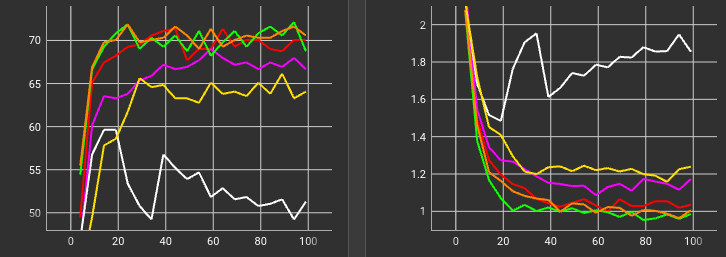

### Real-2-Product

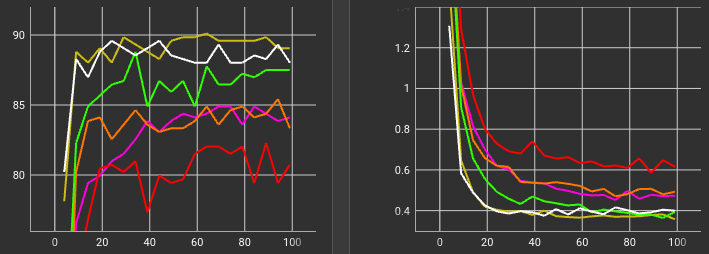

### Table of results

In the following table we reported the results at the last epoch of the mentioned experiments. For each setting, we also report the gain in perfomance of the UDA in each adaptation direction, and the average gain as well.

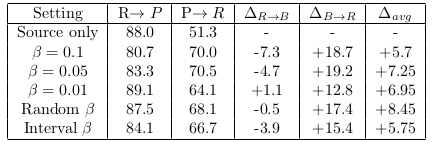

### Discussion

The first thing to notice on the table, in our opinion, is the fact that training on the Real domain still allows the model to get a respectable performance on the Product domain with no need of DA techniques. This is probably due to the fact that the object texture themselves does not visually change from Real to Product domain, which instead only shows a white background. However, in the other direction is it clearly not the same, since the perfomance of the baseline drops dramatically to 51.3.

Looking at the standard FDA experiments, it is safe to say that despite the general improvement in performance in terms of average gain, the gain itself is greatly imbalanced between the two directions. An high $β$ appears to be detrimental in the Real2Product direction, as it lowers the performance instead of raising it. On the other hand, the other direction seem to benefit from an higher $β$. At $β=0.01$ we get the best average performance in the standard setting, although with this value the improvement on the Product target domain is quite low.

The random FDA settings is the experiment which achieve the best performance in terms of gain, although the performance on the Product target domain drops slightly. Note that this setting can also be considered an augmentation, as it forces the model to be more robust to bigger changes in luminosity and low level spectrum. We believe that this also explain the highest performance of the model when using this setting.

The interval FDA setting does not seem to be particularly beneficial, as it hardly reaches the standard setting with $β=0.1$. While we believe that only considering a span of the spectrum may be useful for this method, we recognize that the requirement of choosing two hyperparameters instead of one is quite impractical. Validating this intuition would require more extensive experiments on the spectrum swapping interval.


## Setting 2: Custom Resnet50

In order to validate the effectiveness of our experiments on the standard FDA setting, we also performed a few experiment on a Resnet50 implemented by us. On this backbone we only perform the baseline experiment and one with standard FDA with $β = 0.01$. The following table report the upper bound performance results.

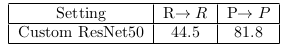

Since this network has to be trained from scratch, we opted for a more aggressive optimizer by using Adam with a learning rate of 0.001. All the other settings remain the same. The following pictures shows the curves of Accuracy (left) and Loss (right), in white the baseline experiment and in red the one with FDA.

### Product-2-Real

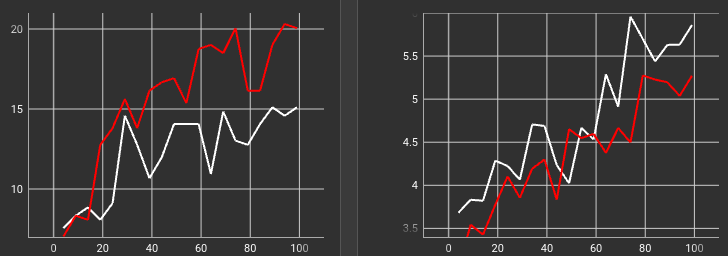

### Real-2-Product

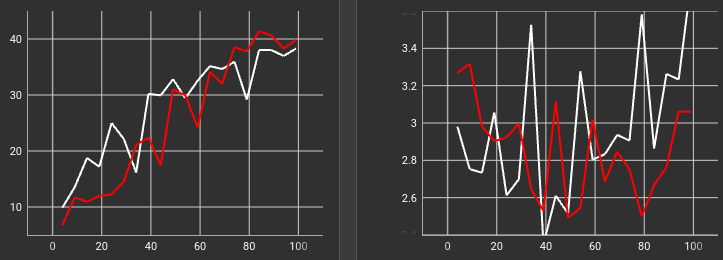

### Table of results

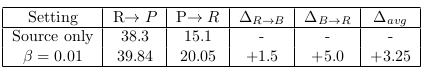

### Discussion

It is clear that our custom Resnet50 does not perform as well as the pretrained one. Looking at the Accuracy and Loss curves, we believe that this is at least partly due to the fact that more epochs are needed to reach a peak performance, since they have not reached a plateau on the training set yet.
However, we believe that this experiment has fulfilled our purpose, since it confirms our findings on the standard FDA setting: as in the experiments with the pretrained Resnet50, the FDA contribution is positive, although it is quite low in the Real2Product direction.

In the following cell we defined the config dictionary used for the baseline experiment in this setting.


In [ ]:
DEBUG = False
EXP1 = {
    # exp configs
    'exp_name': 'custom_res50_prod2real',
    'n_epochs': 100,
    'valid_freq': 5,
    'save_freq' : 5,
    # training configs
    'bs': 64,
    'lr': 1e-3,
    'w_decay': 5e-4,
    'optimizer': 'adam',
    'scheduler': 'cosine',
    'arch': 'custom_resnet50',
    'dropout': 0,
    # uda configs
    'use_fda': False,
    'beta_fda': 0.01,
    'type_fda': 'default',
    'source_domain': 'product_images',
    'target_domain': 'real_life',
    # data configs
    'train_split': 'train',
    'valid_split': 'valid',
    'data_root': 'Adaptiope',
    'img_size': (224,224),
    'use_transforms': True,
    'normalize': True,
    'n_classes': 20
}

In [ ]:
run_experiment(EXP1)

# Conclusion and further developments

In this project we have shown the effect of Fourier Domain Adaptation on an Object Recognition Task. While the general performance appears good, we believe this method to be very dependant on the type of domain, and in particular it appears that it does not perform very well in presence of visual artifact which influence the swapped interval in the image spectrum, such as the white background in the Product domain. However, we have also shown that such performance varies by a great deal depending on the dimension of the span which is swapped, making this technique extremely dependant on hyperparameter choice. Still, to validate this claim it would be beneficial to performs experiments on different domain, starting for example with the Synthetic domain of the Adaptiope dataset, which was not considered in this work. 

Since hyperparameter search may be costly and unfeasable in the presence of more target domain, we believe that future work on this technique could address this dependance. In particular, it would be beneficial to find a way to "learn" the frequency portion itself to be swapped, or to infer it by looking, for example, at the frequency distribution of a certain domain.

## Appendix

Example of how the FDA changes the original source image, applied to two images of different domains, varying the $β$.

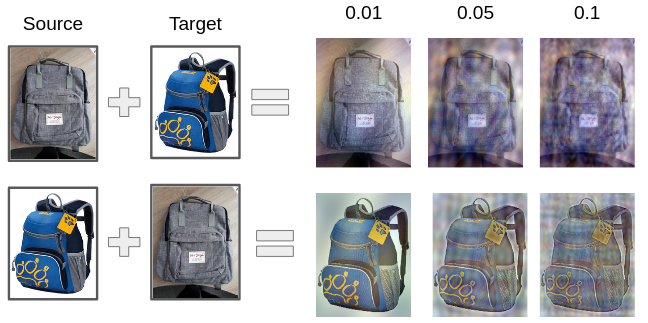

## Bibliography

1. Yang et al., "FDA: Fourier Domain Adaptation for Semantic Segmentation", CVPR 2020
2. Ringwald et al., "Adaptiope: A Modern Benchmark for Unsupervised Domain Adaptation", WAVC 2021
3. He et al, "Deep Residual Learning for Image Recognition", CVPR 2016
4. *PyTorch website*: https://pytorch.org